In [1]:
from fingerLSTM import Finger, Fingers
import matplotlib.pyplot as plt
import numpy as np
from skimage.draw import line_aa
import time
import cv2
import mediapipe as mp
from torch.utils.data import DataLoader, Dataset
from pynput.keyboard import Key,Controller
from sklearn.preprocessing import StandardScaler
from win32com.client import Dispatch
import os
import torch.nn as nn
import torch
from torch.autograd import Variable 

In [2]:
#hand detection
hands = mp.solutions.hands.Hands(static_image_mode=False,
                         max_num_hands=1,
                         min_tracking_confidence=0.5,
                         min_detection_confidence=0.5)

mpDraw = mp.solutions.drawing_utils

In [3]:
cap = cv2.VideoCapture(0)

In [262]:
#TEXT
font = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,30)
fontScale = 1
fontColor = (255,255,255)
fontColor_red = (0, 0, 255)
thickness = 1
lineType = 2
#CAMERA
t = time.time()
fingers = Fingers(30)
while True:
    _, img = cap.read()
    h, w, _ = img.shape
    img = cv2.flip(img, 1)
    result = hands.process(img)
    if result.multi_hand_landmarks:
        x = []
        for id, lm in enumerate(result.multi_hand_landmarks[0].landmark):
            #cv2.circle(img, (cx, cy), 3, (255, 255, 255))
            if id == 4:
                cx, cy = int(lm.x*w), int(lm.y*h)
                x.append([cx, cy])
                cv2.circle(img, (cx, cy), 5, (0, 255, 0))
            if id == 8:
                cx, cy = int(lm.x*w), int(lm.y*h)
                x.append([cx, cy])
                cv2.circle(img, (cx, cy), 5, (0, 255, 255))
            if id == 12:
                cx, cy = int(lm.x*w), int(lm.y*h)
                x.append([cx, cy])
                cv2.circle(img, (cx, cy), 5, (255, 0, 0))
            if id == 16:
                cx, cy = int(lm.x*w), int(lm.y*h)
                x.append([cx, cy])
                cv2.circle(img, (cx, cy), 5, (255, 255, 0))
            if id == 20:
                cx, cy = int(lm.x*w), int(lm.y*h)
                x.append([cx, cy])
                cv2.circle(img, (cx, cy), 5, (255, 255, 255))
        fingers.append(x)
    if time.time()-t >2.4:
        cv2.putText(img,f'{time.time()-t:.2f}', bottomLeftCornerOfText, font, fontScale,fontColor_red,thickness,lineType)
    else:
        cv2.putText(img,f'{time.time()-t:.2f}', bottomLeftCornerOfText, font, fontScale,fontColor,thickness,lineType)
    cv2.imshow("1",img)
    cv2.waitKey(1)
    if time.time()-t>3:
        break
cv2.destroyAllWindows()

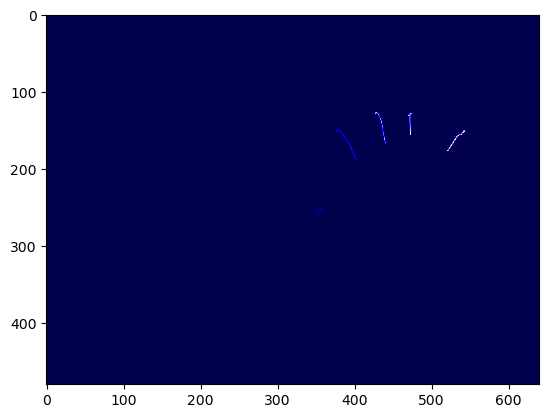

In [263]:
plt.imshow(fingers.image(h, w), cmap='seismic')
plt.show()

In [180]:
stop.append(fingers.get_tensor().numpy())
print(len(stop))

50


In [23]:
#up_volume = []
#low_volume = []
#next_track = []
#trash = []
#stop = []

In [181]:
#np.save('up_volume.npy', up_volume)
#np.save('low_volume.npy', low_volume)
#np.save('next_track.npy', next_track)
#np.save('trash.npy', trash)
#np.save('stop.npy', stop)

In [183]:
up_volume = np.load('up_volume.npy')
low_volume = np.load('low_volume.npy')
data_next = np.load('next_track.npy')
trash = np.load('trash.npy')
stop = np.load('stop.npy')

In [6]:
data_next.shape

(50, 30, 10)

In [184]:
add = []
for sample in up_volume:
    add.append(sample+np.random.normal(0,0.05,[30,10]))
up_volume = np.concatenate((up_volume, add))

add = []
for sample in low_volume:
    add.append(sample+np.random.normal(0,0.05,[30,10]))
low_volume = np.concatenate((low_volume, add))

add = []
for sample in data_next:
    add.append(sample+np.random.normal(0,0.05,[30,10]))
data_next = np.concatenate((data_next, add))

add = []
for sample in trash:
    add.append(sample+np.random.normal(0,0.05,[30,10]))
trash = np.concatenate((trash, add))

add = []
for sample in stop:
    add.append(sample+np.random.normal(0,0.05,[30,10]))
stop = np.concatenate((stop, add))

print(len(up_volume))
print(len(low_volume))
print(len(data_next))
print(len(trash))
print(len(stop))
np.save('up_volume_aug.npy', up_volume)
np.save('low_volume_aug.npy', low_volume)
np.save('next_aug.npy', data_next)
np.save('trash_aug.npy', trash)
np.save('stop_aug.npy', stop)

100
100
100
100
100


In [187]:
class FingerDataset(Dataset):
    def __init__(self, paths):
        up_vol = np.load(paths[0])
        low_vol = np.load(paths[1])
        next_track = np.load(paths[2])
        trash = np.load(paths[3])
        stop = np.load(paths[4])
        
        data = np.append(up_vol, low_vol, axis=0)
        data = np.append(data, next_track, axis=0)
        data = np.append(data, trash, axis=0)
        data = np.append(data, stop, axis=0)
        
        self.data = data
        self.labels = [0]*len(up_vol)+[1]*len(low_vol)+[2]*len(next_track)+[3]*len(trash)+[4]*len(stop)
        
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
    def __len__(self):
        return len(self.data)

In [189]:
paths1 = ['up_volume_aug.npy', 'low_volume_aug.npy', 'next_aug.npy', 'trash_aug.npy', 'stop_aug.npy']
data = FingerDataset(paths1)
print(data.__len__())

500


In [190]:
data_loader1 = DataLoader(data, shuffle=True, batch_size=5)

In [191]:
batch = next(iter(data_loader1))

In [192]:
batch[1]

tensor([4, 0, 3, 1, 0])

In [193]:
class Model(nn.Module):
    def __init__(self, num_layers, hidden_size):
        super(Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=10, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.l1 = nn.Linear(hidden_size, 5)
        self.relu = nn.ReLU()
    def forward(self, x):
        #out = self.CNN(x).view(-1, 1, 180)

        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        
        out, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        return self.l1(hn)

In [194]:
num_layers = 1
hidden_size = 100
model = Model(num_layers, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [195]:
model(torch.randn(3,30,10))

tensor([[-0.0101, -0.0951, -0.0862, -0.0227, -0.1177],
        [-0.0259, -0.1816, -0.0450,  0.0382,  0.0450],
        [-0.0661, -0.1904, -0.0201,  0.0940, -0.0685]],
       grad_fn=<AddmmBackward0>)

In [196]:
num_epochs = 200
for epoch in range(num_epochs):
    for images, labels in data_loader1:
        out = model(images.to(torch.float))
        
        optimizer.zero_grad()
        loss = criterion(out.to(torch.float), labels)
        loss.backward()
        optimizer.step()
    if epoch %10 ==0:
        print(f'Epoch: {epoch}, loss: {loss}')

Epoch: 0, loss: 0.3699711263179779
Epoch: 10, loss: 0.0004774488043040037
Epoch: 20, loss: 0.00027111053350381553
Epoch: 30, loss: 6.029305950505659e-05
Epoch: 40, loss: 3.363993528182618e-05
Epoch: 50, loss: 2.37222029682016e-05
Epoch: 60, loss: 5.316712304193061e-06
Epoch: 70, loss: 8.630679985799361e-06
Epoch: 80, loss: 9.894284630718175e-06
Epoch: 90, loss: 3.0517498998960946e-06
Epoch: 100, loss: 5.722043852074421e-07
Epoch: 110, loss: 5.245207148618647e-07
Epoch: 120, loss: 5.006788228456571e-07
Epoch: 130, loss: 4.0531145373279287e-07
Epoch: 140, loss: 1.907348377017115e-07
Epoch: 150, loss: 1.9073479506914737e-07
Epoch: 160, loss: 0.0
Epoch: 170, loss: 0.0
Epoch: 180, loss: 0.0
Epoch: 190, loss: 0.0


In [278]:
## lev=0
t = time.time()
fingers = Fingers(30)
#WMP
lev=0
mp = Dispatch("WMPlayer.OCX", 0)
for song in os.listdir("C:/Users/Artem/Desktop/Artem/volume_hand_project/Playlist"):
    tune1 = mp.newMedia("C:/Users/Artem/Desktop/Artem/volume_hand_project/Playlist/"+song)
    mp.currentPlaylist.appendItem(tune1)
mp.settings.volume=10
while True:
    _, img = cap.read()
    h, w, _ = img.shape
    img = cv2.flip(img, 1)
    result = hands.process(img)
    if result.multi_hand_landmarks:
        x = []
        for id, lm in enumerate(result.multi_hand_landmarks[0].landmark):
            #cv2.circle(img, (cx, cy), 3, (255, 255, 255))
            if id == 4:
                cx, cy = int(lm.x*w), int(lm.y*h)
                x.append([cx, cy])
                cv2.circle(img, (cx, cy), 5, (0, 255, 0))
            if id == 8:
                cx, cy = int(lm.x*w), int(lm.y*h)
                x.append([cx, cy])
                cv2.circle(img, (cx, cy), 5, (0, 255, 255))
            if id == 12:
                cx, cy = int(lm.x*w), int(lm.y*h)
                x.append([cx, cy])
                cv2.circle(img, (cx, cy), 5, (255, 0, 0))
            if id == 16:
                cx, cy = int(lm.x*w), int(lm.y*h)
                x.append([cx, cy])
                cv2.circle(img, (cx, cy), 5, (255, 255, 0))
            if id == 20:
                cx, cy = int(lm.x*w), int(lm.y*h)
                x.append([cx, cy])
                cv2.circle(img, (cx, cy), 5, (255, 255, 255))
        fingers.append(x)
    if fingers.check():
        pred = model(fingers.get_tensor().view(1,30,10)).detach().numpy()[0]
        ind = np.argmax(pred)
        val = pred[ind].item()
        if pred[3].item()<-1:
            #up volume
            if(ind==0 and val>=15):
                mp.settings.volume+=5
                print(mp.settings.volume)
                fingers.clear()
            #down volume
            if(ind==1 and val>=15):
                mp.settings.volume-=5
                print(mp.settings.volume)
                fingers.clear()
            #next
            if(ind==2 and val>=15):
                mp.controls.next()
                print('next')
                fingers.clear()
            #play/stop
            if(ind==4 and val>=12):
                if(lev==0):
                    mp.controls.play()
                    lev=1
                    print('play')
                else:
                    mp.controls.pause()
                    lev=0
                    print('pause')
                fingers.clear()
    cv2.imshow("1", img)
    cv2.waitKey(1)
    if time.time()-t>120:
        break
cv2.destroyAllWindows()

play
pause
15
20
25
play
pause
play
30
35
40
45
pause
next
next
play
50
55
60
next
pause
play
55
50
55
60
65
70
75
80
next
pause
play
next
75


In [279]:
mp.controls.pause()